In [129]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx
import scipy.stats
import time

import argraph as ag        # Our custom class

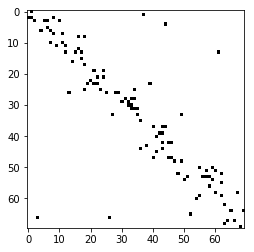

In [145]:
nNodes = 70
A = ag.create(n=nNodes)
# Defaults: create(n=50, minCommunity=3, tauCommunity=1.2, tauDegree=1):

plt.imshow(A, cmap="Greys");

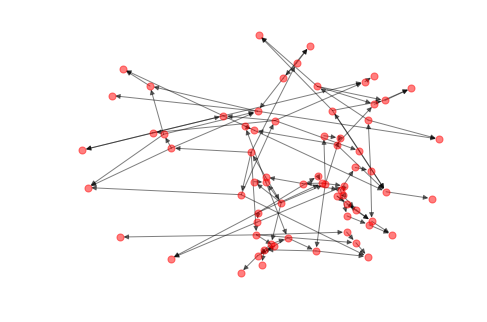

In [146]:
G = nx.DiGraph()
G = nx.from_numpy_matrix(A,create_using=G)
nx.draw_spring(G,node_size=50,alpha=0.5,iterations=100)

We may be tempted to just add normal noise to matrix A, and call it a noisy matrix. But of course $r>1$ do not exist, and neither do TE$>1$, so this formula won't work. Even for $r$, a relatively simple meausure, ,the true formula for distributions of observed sample $r$ around true $\rho$ is apparently quite scary. For $\rho=0$ it looks vaguely normalish, at least around 0, and for $\rho=1$ it looks sort of chi-square-ish, so they can be roughly approximated.

I was originally tempted to A is a matrix of $r$, and model dissolution of $r$ around $\rho$ explicitly. But then I remembered that in most cases A won't be observed as r, and so this approach does not really work. It's better to be simpler here.

A better option therefore is to noisify with two different empirical distributions for those pairs where $\rho=0$ and those with $\rho=1$. Or, in a weighted case, with a formula that works on a whole range or $\rho \in [0,1]$. Such as a normal distribution wrapped within $[0,1]$, for example.

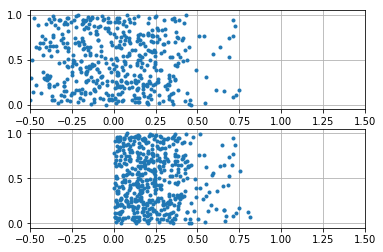

In [118]:
# Useful wrapper, and a test of it
def mywrap(a):
    # This function reflects values below 0 upwards (like abs()), 
    # and also wraps values above 1 downwards (like 1-abs(1-x)).
    # It wraps it like a ribbon, in a zig-zag fashion.
    return 1/2 + (a-np.floor(a)-1/2)*(-1)**np.floor(a)

x = np.random.normal(0,0.3,500)
y = np.random.uniform(0,1,500)

plt.subplot(211)
plt.plot(x,y,'.')
plt.xlim(-0.5,1.5)
plt.grid()
plt.subplot(212)
plt.plot(mywrap(x),y,'.')
plt.xlim(-0.5,1.5)
plt.grid()

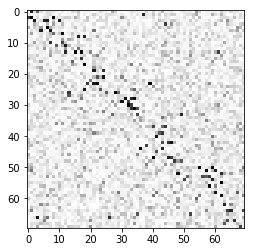

In [147]:
# Empirical approach:

noiseLevel = 0.2
Anoisy = mywrap(A + np.random.normal(0, noiseLevel, size=np.shape(A)))
plt.imshow(Anoisy, cmap="Greys");

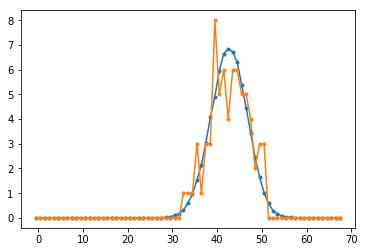

In [148]:
nShuffles = 1000

# --- Prototyping:
# --- Yet without a loop, look at individual histograms and their reshuffled counterparts

threshold = 0.1
Aproxy = 1*(Anoisy>threshold)
#plt.imshow(Aproxy, cmap="Greys")

degIn = np.sum(Aproxy,0) # 0 for 1st index = in-degree; 1 for out-degree
h = np.histogram(degIn,bins=np.arange(0,nNodes)-0.5)

nEdges = int(sum(Aproxy.reshape(-1)))

hSh = h[0]*0      # Zeros, same size
for iShuffle in range(0,nShuffles):
    Arandom = np.zeros(nNodes*nNodes)
    Arandom[np.random.permutation(nNodes*nNodes)[1:nEdges]] = 1
    Arandom = Arandom.reshape([nNodes,nNodes])
    degIn = np.sum(Arandom,0) # 0 for 1st index = in-degree; 1 for out-degree
    hSh = hSh + np.histogram(degIn,bins=np.arange(0,nNodes)-0.5)[0]
hSh = hSh/nShuffles

plt.plot(h[1][0:-1],hSh,'.-')
plt.plot(h[1][0:-1],h[0],'.-')
plt.show()

The most obvious type of divergence between 2 probability distributions is Kullback-Leibler divergence, which is essentially a generalizatin of entropy. It is not a distance, as it's not symmetric, but it quantifies how different one distribution is from another distribution:

https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence 

$D = -\sum{p_i \cdot \text{log}(\frac{q_i}{p_i})}$

Now, because there's a division by $p_i$ in this formula, $p$ cannot be $=0$ anywhere. That's why we have to add those `1e-10`s, to prevent Inf as output.

https://datascience.stackexchange.com/questions/11320/kl-divergence-returns-infinity

In principle, the first input in `scipy.stats.entropy` is p, and the second is q. The function then returns how unusual q is compared to p:

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.entropy.html

this seems to imply that the 'expected' distribution should be the first one, and in our case the 'expected' distribution is the one from and Erdos graph, so it should be the reshuffled distribution. And then we should look how 'unexpected' the actually observed distribution is, compared to the 'expected' one. For some reason, in practice the opposite (using `vec2` - the observed distribution - as the target one, and `vec1` - the random reshuffled - as "surprizing one") works much better. With correct use, the function is always super-jagged, and the peak is quite a bit higher than a true value. With 'incorrect use', the peak is smooth, and seems to be closer to the true value, usually. Not sure what to make of it.

It seems that it is a known issue though, related to the fact that KL diveregence is not smooth. So in practice people often use a 'Symmetrized' version of it, called Jensen-Shannon divergence:

https://en.wikipedia.org/wiki/Jensen%E2%80%93Shannon_divergence

Alternative: Jensen–Shannon divergence

Also, this time coded explicitly, as zip-sums, without reliance on numpy entropy

https://stackoverflow.com/questions/15880133/jensen-shannon-divergence

```{python}
vecMid = (vec1+vec2)/2
kl1 = sum(p * np.log(p / q) for p, q in zip(vec1,vecMid) if p != 0) # KL1
kl2 = sum(p * np.log(p / q) for p, q in zip(vec2,vecMid) if p != 0) # KL1
js = (kl1+kl2)/2```

In [149]:
# --- Full version, as a function
def guess(Anoisy,nSteps=None,nShuffles=None):
    if nSteps is None: nSteps = 100            # How many different thresholds to try
    if nShuffles is None: nShuffles = 100        # How many Erdos graphs to generate. For a 50x50 graph 100 seems surprisingly OK
    perMin = 50             # Min percentile (share of edges to reject)
    perMax = 100            # Max percentile (share of edges to reject)
    Adim = np.shape(Anoisy)[1]

    diverge = [0]*nSteps
    nEdges = [0]*nSteps
    #thresholds = np.linspace(start=np.median(Anoisy), stop=np.max(Anoisy), num=nSteps)
    thresholds = [0]*nSteps
    # We can safely assume that less than half of edges exist (true for most realistic networks)
    
    for i in range(0,nSteps):
        thresholds[i] = np.percentile(Anoisy,perMin + i/nSteps*(perMax-perMin))
        #thresholds[i] = i/nSteps
        Aproxy = 1*(Anoisy>thresholds[i])

        degIn = np.sum(Aproxy,0) # 0 for 1st index = in-degree; 1 for out-degree
        h = np.histogram(degIn,bins=np.arange(0,nNodes)-0.5)

        nEdges[i] = sum(Aproxy.reshape(-1))
        
        hSh = h[0]*0      # Zeros, same size
        for iShuffle in range(0,nShuffles):
            Arandom = np.zeros(nNodes*nNodes)
            Arandom[np.random.permutation(nNodes*nNodes)[1:nEdges[i]]] = 1
            Arandom = Arandom.reshape([nNodes,nNodes])
            degIn = np.sum(Arandom,0) # 0 for 1st index = in-degree; 1 for out-degree
            hSh = hSh + np.histogram(degIn,bins=np.arange(0,nNodes)-0.5)[0]
        hSh = hSh/nShuffles

        # JS divergence:
        vec1 = hSh/sum(hSh) + 1e-10
        vec2 = h[0]/sum(h[0]) + 1e-10
        vecMid = (vec1+vec2)/2
        kl1 = sum(p * np.log(p / q) for p, q in zip(vec1,vecMid) if p != 0) # KL1
        kl2 = sum(p * np.log(p / q) for p, q in zip(vec2,vecMid) if p != 0) # KL1    
        diverge[i-1] = (kl1+kl2)/2

    # Post-loop:
    besti = np.argmax(diverge)
    
    return (nEdges, diverge, thresholds, besti)

In [150]:
# Actually run the program: try to guess the threshold
# With nSteps=100 and nShuffles=1000 takes ~15 s

tic = time.time()
(nEdges, diverge, thresholds, besti) = guess(Anoisy,nSteps=1000,nShuffles=100)
print("Time passed: ",time.time()-tic)

Time passed:  18.13103699684143


Regression-based guess:  0.7333207853201096


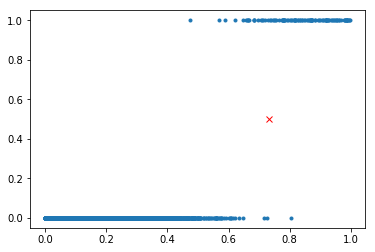

In [151]:
# Logistic regression threshold for this data
# (Actually not the best idea - see below)

from sklearn.linear_model import LogisticRegression
clf = LogisticRegression().\
    fit(Anoisy.reshape(-1,1) , A.ravel()) # Wants 2D for X, but 1D for Y. Gets upset.
optimalThreshold = float(-clf.intercept_/clf.coef_)

#print(np.sum(Anoisy.ravel()<optimalThreshold * (A.ravel()==1)))
#print(np.sum(Anoisy.ravel()>optimalThreshold * (A.ravel()==0)))

plt.plot(Anoisy.reshape(-1,1),A.ravel(),'.');
plt.plot(optimalThreshold,0.5,'rx');

print("Regression-based guess: ",optimalThreshold)

Actually, as we see, logistic regression doesn't give us the "best" threshold, in terms of minimizing total error. Probably because it uses a symmetric logistic function? It should be better to just explicitly find a threshold that minimizes the number of wrong edge attributions.

Explicit optimization threshold:  0.6483908291872162


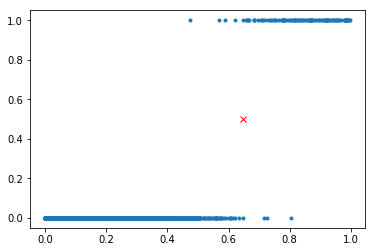

In [152]:
# Better solution: explicitly find best threshold

indices = np.argsort(Anoisy.ravel())
# plt.plot(Anoisy.ravel()[indices]) # <- this would make a nicely sorted array

err = [0]*np.size(A)
ar = A.ravel()[indices]
for i in range(0,np.size(A)):
    err[i] = np.sum(ar[0:i]==1) + np.sum(ar[i:]==0)
    
#plt.plot(err);

optimalThreshold = Anoisy.ravel()[indices[np.argmin(err)]]
print("Explicit optimization threshold: ",optimalThreshold)

plt.plot(Anoisy.ravel(),A.ravel(),'.');
plt.plot(optimalThreshold,0.5,'rx');

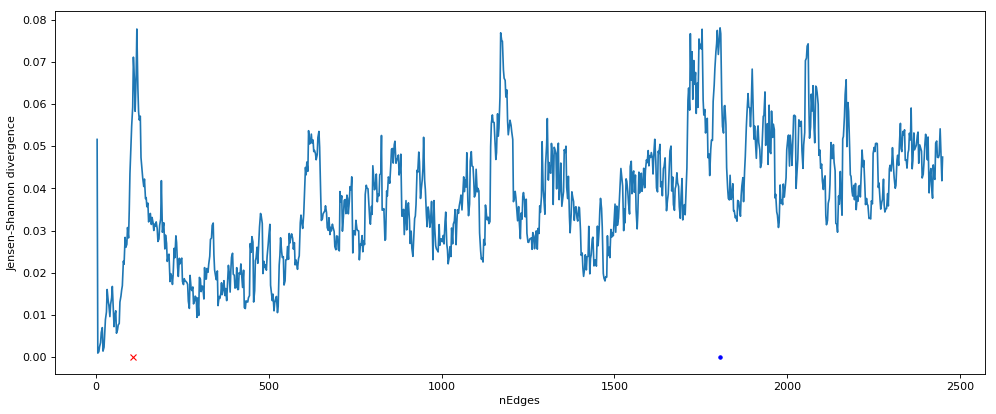

In [153]:
fig=plt.figure(figsize=(15, 6), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(nEdges,diverge,'-')

nEdgesTrue = np.sum(A)
plt.plot(nEdgesTrue,0,'rx')
plt.plot(nEdges[besti],0,'b.')

plt.xlabel('nEdges');
plt.ylabel('Jensen-Shannon divergence');

Note: we often have a spike in divergence for a very low number of edges (around 5, for a 50x50 graph). That's not too good. But also it may be treated as a special case, as it corresponds to a very sparce graph.

It looks like, generally, a good quesiton is now "how" we can guess a threshold, but "whether" we can guess a threshold from distribution alone. Whether it's enough. And perhaps the response is "no, it's not enough, as there may be several peaks of non-randomness"

And then the next question would be, can we detect minutae changes in density if we know the density approximately. In other words, split the question in two: rough estimation of density (say, 2% of edges vs 10% vs 20%), and then detecting fine differences in density (assuming that the generating process remains largely the same).

Text(0,0.5,'Jensen-Shannon divergence')

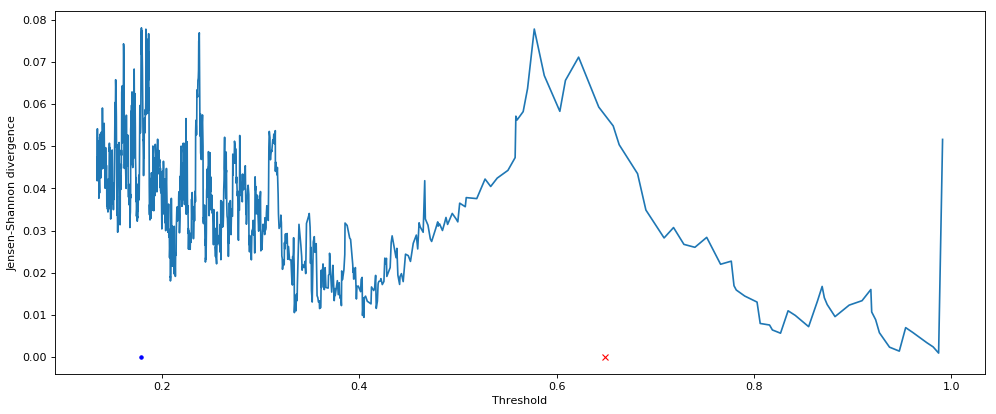

In [154]:
fig=plt.figure(figsize=(15, 6), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(thresholds,diverge,'-')

plt.plot(optimalThreshold,0,'rx')
plt.plot(thresholds[besti],0,'b.')

plt.xlabel('Threshold')
plt.ylabel('Jensen-Shannon divergence')